In [21]:
import pandas as pd
import import_ipynb
import os
from email_processing import emails
from tqdm import tqdm
import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt

In [176]:
email_dfs = []
for employee_dict in emails:
    all_emails = pd.concat([employee_dict['Inbox'],employee_dict['Sent']])
    email_dfs.append(all_emails)

all_emails = pd.concat(email_dfs)
print(len(all_emails))

148547


In [ ]:
# sample = all_emails.sample(n=1000)
# sample.to_csv('../data/interim/training_data_1k.csv')

In [ ]:
all_emails.columns.tolist()

In [ ]:
def find_profanity(row):
    cursewords=['fuck','bitch','asshole','shit','idiot','moron','damn','dammit','damnit','fuk','fck','fker','fkng','bullshit']
    curse_found = 0
    for curseword in cursewords:
        if curseword in row['Body']:
            curse_found = 1
        else:
            continue
    return curse_found


all_emails['potential_curseword'] = all_emails.progress_apply(lambda row: find_profanity(row), axis=1)
    

In [ ]:
curse_word_subset = all_emails[all_emails['potential_curseword'] == 1]
#curse_word_subset.to_csv('../../enron/data/interim/training_data_cursewords.csv')

In [ ]:
all_emails.iloc[1200].Date

In [238]:
import re
import calendar
from datetime import datetime as dt

def find_years(day, month, weekday, start_year=1997, end_year=2003):
    weekday = weekday.capitalize()
    years = []
    weekday_index = None
    for i, name in enumerate(calendar.day_name):
        if name.startswith(weekday):
            weekday_index = i
            break
    if weekday_index is None:
        raise ValueError(f"Invalid weekday abbreviation: {weekday}")
    
    for year in range(start_year, end_year + 1):
        date_string = f"{day} {month} {year}"
        try:
            date_object = dt.strptime(date_string, "%d %b %Y")
        except ValueError:  # Handle invalid dates like 30 Feb
            continue
        if date_object.weekday() == weekday_index:
            years.append(year)
    return years

def is_spaced_date(date_str):
    # This pattern checks if there are spaced out letters as in the problem case.
    spaced_pattern = re.compile(r'(?:\b\s*[A-Za-z]\s*){3,}')
    return bool(spaced_pattern.search(date_str))

def clean_spaced_date(date_str):
    # This function will clean up spaces between letters, digits, and around commas.
    words_with_spaces = re.findall(r'(\b\s*[A-Za-z]+\s*\b|\b\s*[0-9]+\s*\b)', date_str)
    
    for word in words_with_spaces:
        # Remove leading and trailing spaces and join the characters together.
        cleaned_word = ''.join(word.split())
        # Replace the original "word" in date_str with its "cleaned" version.
        date_str = date_str.replace(word, cleaned_word)
    
    # Clean up spaces around commas and ensure single space between month and day
    date_str = re.sub(r'\s*,\s*', ', ', date_str)
    date_str = re.sub(r'(\b[A-Za-z]+\b)\s+(\b\d+\b)', r'\1 \2', date_str)

    # Also, ensure there are no multiple spaces anywhere in the string.
    date_str = re.sub(r'\s{2,}', ' ', date_str)
    
    return date_str.strip()

def custom_date_parser(row):
    date_string = row['Date'].strip()
    original_date_string = date_string

    date_string = re.sub(r"(\d+)(st|nd|rd|th)", r"\1", date_string)

    date_formats = ["%a, %d %b %Y %H:%M:%S %z", "%A, %B %d, %Y", "%m/%d/%y %I:%M %p", "%m/%d/%Y %I:%M %p", 
    "%a, %d %b %Y %H:%M:%S %z", "%A, %B %d , %Y", "%a, %d %b %Y %H:%M:%S %Z", "%B %d, %Y", "%B %Y", 
    "%m-%d-%Y %H:%M:%S", "%d %b %Y %H:%M:%S %z", "%b. %d, %Y", "%A, %B %d, %Y %I:%M %p", "%d %b %y %H:%M:%S %z", 
    "%m/%d/%Y %I:%M %p ", "%a, %d %b %Y %H:%M:%S %Z", "%a, %d %b %Y %H:%M:%S", "%d/%m/%y", "%d %B %Y", "%m/%d/%Y", 
    "%d %B %Y %H:%M", "%B %d %Y", "%A %d %B %Y", "%A, %b. %d %Y", "%m/%d/%Y %I:%M:%S %p", "%a, %d %b %Y", "%A , %b %d, %Y", 
    "%A , %b. %d, %Y", "%m/%d/%y", "%A %B %d, %Y %H:%M", "%m/%d/%y %I:%M%p %z", "%a %m/%d/%y", "%m/%d/%Y %I:%M%p", 
    "%a %d %B %Y %I:%M:%p", "%d/%m/%Y %H:%M", "%A %B %d %Y", "%A, %B%d, %Y", '%a, %b %d, %Y,', "%m/%d/%y %H:%M", 
    "%A, %b %d, %Y", "%a, %b %d, %Y, %I:%M %p", "%a, %d %b %Y %H:%M:%S", '%A, %B %d, %Y, %I:%M:%S %p', "%A, %B %d %Y", 
    "%A, %B %d, %Y %H:%M:%S %Z", "%a, %d %b %Y %H:%M %z", "%m-%d-%y"]

    weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

    if "(" in date_string: ## Removing time zones in parentheses that pd.to_datetime() cannot parse
        date_string = date_string.split(" (")[0]
    
    if re.search(r"\b000[0-9]", date_string):  ## Dates mistakely formatted as 9/8/0002 for example
        date_string = date_string.replace("000", "200")

    if " and " in date_string: ## For dates that are ranges with 'and'
        day_of_week = [x for x in weekdays if x in date_string]
        if len(day_of_week) >= 1:
            weekday = day_of_week[0]
            month = date_string.split(' and ')[0].split(', ')[1].split(' ')[0]
            day = date_string.split(' and ')[0].split(', ')[1].split(' ')[1]
            try:
                possible_years = find_years(day, month, weekday)
                if len(possible_years) == 1:
                    year = possible_years[0]
                    date_string = date_string + str(year)
                else:
                    return pd.NaT
            except Exception as e:
                #print(date_string)
                #print(e)
                return pd.NaT
        else:
            #print(f'Unable to parse: {date_string}')
            return pd.NaT

    if re.search(r'\bat\b', date_string): ## For dates that include the string 'at' to indicate time -- e.g. Jan. 7th at 1pm
        date_string = date_string.split(' at ')[0]
        weekday = date_string.split(', ')[0]
        month = date_string.split(', ')[1].split(' ')[0]
        day = date_string.split(', ')[1].split(' ')[1]
        try:
            possible_years = find_years(day, month, weekday)
            if len(possible_years) == 1:
                year = possible_years[0]
                date_string = date_string + str(year)
            else:
                return pd.NaT
        except Exception as e:
            #print(date_string)
            #print(e)
            return pd.NaT

    if ' - ' in date_string: ## For dates that are formatted as ranges with a ' - '
        date_string = date_string.split(' - ')[0]
        possible_years = ['1997','1998','1999','2000','2001','2002','2003']
        year = [x for x in possible_years if x in date_string]
        if len(year) == 0:
            #print(f'Unable to parse date: {date_string}')
            return pd.NaT
        else:
            pass

    if ' PDT' in date_string: ## To replace invalid timezone
        date_string = date_string.replace("PDT", "").strip()

    if ' EDT' in date_string: ## To replace invalid timezone
        date_string = date_string.replace("EDT", "").strip()

    if ' PST' in date_string: ## To replace invalid timezone
        date_string = date_string.replace("PST", "").strip()

    if ' CST' in date_string: ## To replace invalid timezone
        date_string = date_string.replace("CST", "").strip()

    if ' Central Standard Time' in date_string: ## To replace invalid timezone
        date_string = date_string.replace("Central Standard Time", "").strip()

    if re.match(r"(?i)^(Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday),\s(January|February|March|April|May|June|July|August|September|October|November|December)\s+([1-9]|[12][0-9]|3[01])$", date_string):
        ## For dates formatted like -- Thursday, March 9
        weekday = date_string.split(', ')[0]
        month = date_string.split(', ')[1].split(' ')[0].strip()
        day = date_string.split(', ')[1].split(' ')[1].strip()
        try:
            possible_years = find_years(day, month, weekday)
            if len(possible_years) == 1:
                year = possible_years[0]
                date_string = date_string + ' ' + str(year)
            else:
                return pd.NaT
        except Exception as e:
            #print(date_string)
            #print(e)
            return pd.NaT

    elif re.match(r"\b(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday),\s(?:[1-9]|[12][0-9]|3[01])\s(?:January|February|March|April|May|June|July|August|September|October|November|December)\b$", date_string):
        ## For dates formatted like -- Thursday, 9 March
        weekday = date_string.split(', ')[0]
        month = date_string.split(', ')[1].split(' ')[1]
        day = date_string.split(', ')[1].split(' ')[0]
        try:
            possible_years = find_years(day, month, weekday)
            if len(possible_years) == 1:
                year = possible_years[0]
                date_string = date_string + ' ' + str(year)
            else:
                return pd.NaT
        except Exception as e:
            #print(date_string)
            #print(e)
            return pd.NaT

    elif re.match(r"\b([01]?[0-9]|2[0-3]):([0-5][0-9]):([0-5][0-9])\s(AM|PM)\sToday\b", date_string): ## For dates formatted like 03:30:47 PM Today
        return pd.NaT

    elif re.match(r"\b(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{1,2}-\d{1,2},\s\d{4}\b", date_string):
        ## For dates formatted like September 10-13, 2001
        date_string = date_string.split('-')[0] + ', ' + date_string.split(', ')[1]
    
    elif re.match(r"\b(?:Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday),\s(?:Jan\.|Feb\.|Mar\.|Apr\.|May|Jun\.|Jul\.|Aug\.|Sep\.|Oct\.|Nov\.|Dec\.)\s[0-3]?[0-9]$", date_string):
        ## For dates formatted like Tuesday, Feb. 27
        weekday = date_string.split(', ')[0]
        month = date_string.split(', ')[1].split(' ')[0]
        day = date_string.split(', ')[1].split(' ')[1]
        try:
            possible_years = find_years(day, month, weekday)
            if len(possible_years) == 1:
                year = possible_years[0]
                date_string = date_string + ' ' + str(year)
            else:
                return pd.NaT
        except Exception as e:
            #print(date_string)
            #print(e)
            return pd.NaT

    elif re.match(r"\b(?:Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday),\s(?:January|February|March|April|May|June|July|August|September|October|November|December)\s(?:[1-9]|[12][0-9]|3[01])(?!\s*(?:\d{4}|\d{1,2}:\d{2}))\b", date_string):
        ## For dates formated like Thursday, February 15 Friday, February 16
        date_string = ' '.join(date_string.split(' ')[:3])
        weekday = date_string.split(', ')[0]
        month = date_string.split(', ')[1].split(' ')[0]
        day = date_string.split(', ')[1].split(' ')[1]
        try:
            possible_years = find_years(day, month, weekday)
            if len(possible_years) == 1:
                year = possible_years[0]
                date_string = date_string + str(year)
            else:
                return pd.NaT
        except Exception as e:
            #print(date_string)
            #print(e)
            return pd.NaT

    elif re.match(r"\bToday,\s(Tuesday|Monday|Wednesday|Thursday|Friday|Saturday|Sunday),\s(January|February|March|April|May|June|July|August|September|October|November|December)\s([1-9]|[12][0-9]|3[01]),\s(\d{4})\b", date_string):
        ## For dates formatted like Today, Tuesday, February 6, 2001
        date_string = date_string.replace("Today, ", "")

    elif "Msg" in date_string: ## Dates formatted with Msg at the end
        date_string = date_string.replace('Msg', '').strip()

    if "Sept" in date_string: ## Invalid abbreviation for September
            date_string = date_string.replace("Sept", "Sep")
        
    if "Sepember" in date_string: ## Typo in September
        date_string = date_string.replace("Sepember", "September")

    if "Noevember" in date_string: ## Typo in November
        date_string = date_string.replace("Noevember", "November")

    if "Time" in date_string: ## Unnecessarily included in some date strings
        date_string = date_string.replace("Time", "").strip()
    
    if "-UT" in date_string: ## Dates formatted like Thursday, May 3, 2001 -0100-UT
        date_string = date_string.replace("-UT", "").strip()

    if "=20" in date_string: ## Dates formatted like Mon, 24 Sep 2001 15:04:53 -0500=20
        date_string = date_string.replace("=20","").strip()

    if date_string in ["Daily", "Weekly on Monday's", "Thursday, 10 a.m.", "TODAY", "Every Monday", "Every Thursday", "_______________   Name", "1853", "14 century", "of, 15 ssa 2000 09:40:34 -0600"]:
        ## Unique cases of unidentifiable dates
        return pd.NaT

    if "Written by Ted Nugent, the rock singer" in date_string: ## Weird edge case
        date_string = date_string.replace("Written by Ted Nugent, the rock singer", "").strip()

    if ", 1835edt" in date_string: ## Another weird edge case
        date_string = date_string.replace(", 1835edt", "").strip()

    for format in date_formats:
        try:
            return pd.to_datetime(date_string, format=format).date()
        except Exception as exc:
            pass
        else:
            break
    else:
        #print(date_string)
        #print(original_date_string)
        return pd.NaT

In [239]:
tqdm.pandas()
all_emails['fixed_date'] = all_emails.progress_apply(lambda row: custom_date_parser(row), axis=1)

100%|██████████| 148547/148547 [00:14<00:00, 10272.84it/s]


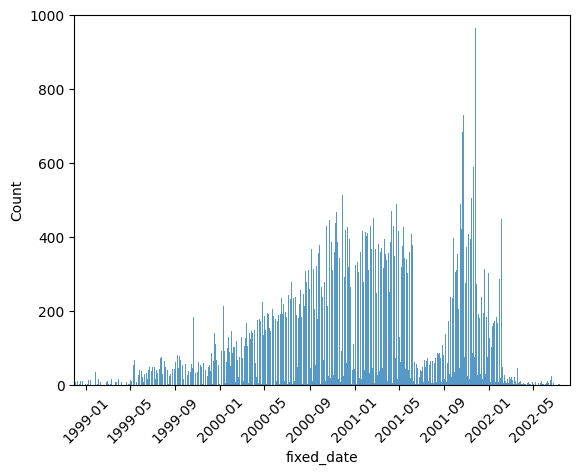

In [248]:
all_emails.reset_index(drop=True, inplace=True)

plt.figure()

sns.histplot(data=all_emails, x='fixed_date')
plt.xlim(datetime.date(1998,12,1),datetime.date(2002,8,11))
plt.ylim(0,1000)
plt.xticks(rotation=45)

plt.show()

In [249]:
emails_9_11 = all_emails[(all_emails['fixed_date'] >= datetime.date(2001, 9, 11)) & (all_emails['fixed_date'] <= datetime.date(2001, 9, 15))]
print(len(emails_9_11))

501


In [250]:
emails_9_11.to_clipboard()

In [251]:
all_emails.to_csv('../data/processed/full_dataset.csv')